In [1]:
# Import Packages and setup
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import sep
from astropy.table import Table as ApTable
from astropy.io import fits
from lsst.meas.deblender import proximal, display, sim, baseline
import lsst.meas.deblender.utils as debUtils

import scarlet

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.INFO)
dlogger = logging.getLogger("scarlet")
dlogger.setLevel(logging.INFO)

In [8]:
def loadData(id):
    path = '/Users/fred/lsst/code/scarlet_paper/cosmos/'
    bands = ['g','r','i','z','y']
    data = {"img":[],"weights":[],"psf":[],"masks":[]}
    img_types = ['','psf_','mask_','var_']
    labels = {"img":'',"weights":'var_',"psf":'psf_',"masks":'mask_'}

    for band in bands:
        for k in data.keys():
            hdu = fits.open(path + "example_%d_%s%s.fits" % (id, labels[k],band))
            data[k].append(hdu[0].data)
            hdu.close()
    for k in data.keys():
        data[k] = np.array(data[k])

    return data

def makeCatalog(data):
    detect = data['img'].mean(axis=0)
    bkg = sep.Background(data['img'].mean(axis=0))
    objects = sep.extract(detect, 1.2, err=bkg.globalrms, deblend_nthresh=64, deblend_cont=3e-4)
    sky_bkg = np.array([sep.Background(img).globalrms for img in data['img']])
    return objects, sky_bkg

In [9]:
import imp
imp.reload(scarlet)
imp.reload(scarlet.source)
imp.reload(scarlet.blend)
imp.reload(scarlet.operators)
imp.reload(scarlet.transformations)
imp.reload(scarlet)

<module 'scarlet' from '/Users/fred/lsst/code/scarlet/scarlet/__init__.py'>

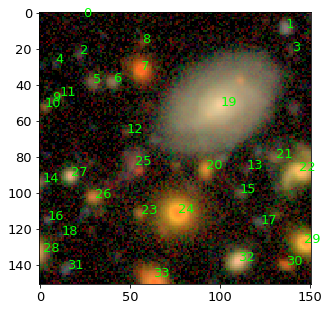

In [12]:
idx = 3

data = loadData(idx)
catalog, bg_rms = makeCatalog(data)

vmin = 0
vmax = .2
display.plotColorImage(images=data["img"], filterIndices=[3,2,1], Q=8, show=False, figsize=(5,5), vmin=vmin, vmax=vmax)
for m,src in enumerate(catalog):
    plt.text(src["x"], src["y"], str(m), color='lime')
plt.show()

constraints = {"S": None, "m": {'use_nearest': False}, "+": None}
shape = (len(data['img']), 15, 15)
gamma = None
#sources = [scarlet.Source((obj['y'],obj['x']), shape, psf=gamma, K=1, constraints=constraints, shift_center=0) for obj in catalog]

from functools import partial
bulge_disk = partial(scarlet.source.init_bulge_disk)
#sources = [scarlet.Source((obj['y'],obj['x']), shape, psf=gamma, K=2, constraints=constraints, init_func=bulge_disk) for obj in catalog]
sources = [scarlet.Source((obj['y'],obj['x']), shape, psf=gamma, K=1, constraints=constraints) for obj in catalog]

img = data['img']
weights=None
blend = scarlet.Blend(sources, img, weights=weights, bg_rms=bg_rms)

In [13]:
#blend.fit(0)
#blend.fit(20)
#blend.remove_degenerate_components(1e-3)
#blend.fit(40)
#blend.remove_degenerate_components(1e-3)
blend.fit(300)

INFO:scarlet.blend:resizing source 0 from (3,9) to (13,19) at it 10
INFO:scarlet.blend:max height: 299, width:255
INFO:scarlet.blend:resizing source 2 from (9,9) to (19,19) at it 10
INFO:scarlet.blend:max height: 257, width:259
INFO:scarlet.blend:resizing source 3 from (9,9) to (19,19) at it 10
INFO:scarlet.blend:max height: 261, width:281
INFO:scarlet.blend:resizing source 4 from (5,5) to (15,15) at it 10
INFO:scarlet.blend:max height: 247, width:285
INFO:scarlet.blend:resizing source 5 from (11,19) to (21,29) at it 10
INFO:scarlet.blend:max height: 225, width:243
INFO:scarlet.blend:resizing source 6 from (15,17) to (25,27) at it 10
INFO:scarlet.blend:max height: 227, width:221
INFO:scarlet.blend:resizing source 7 from (29,27) to (29,37) at it 10
INFO:scarlet.blend:max height: 239, width:191
INFO:scarlet.blend:resizing source 8 from (9,9) to (19,19) at it 10
INFO:scarlet.blend:max height: 271, width:189
INFO:scarlet.blend:resizing source 9 from (9,11) to (19,21) at it 10
INFO:scarlet.

INFO:scarlet.blend:resizing source 28 from (23,3) to (33,13) at it 200
INFO:scarlet.blend:max height: 267, width:299
INFO:scarlet.blend:resizing source 33 from (29,39) to (39,39) at it 210
INFO:scarlet.blend:max height: 297, width:177
INFO:scarlet.blend:resizing source 14 from (9,3) to (19,13) at it 220
INFO:scarlet.blend:max height: 189, width:299
INFO:scarlet.blend:resizing source 28 from (33,13) to (33,23) at it 230
INFO:scarlet.blend:max height: 273, width:301
INFO:scarlet.blend:resizing source 28 from (23,3) to (33,13) at it 260
INFO:scarlet.blend:max height: 267, width:299
INFO:scarlet.blend:resizing source 14 from (19,13) to (29,13) at it 270
INFO:scarlet.blend:max height: 189, width:301
INFO:scarlet.blend:resizing source 28 from (33,13) to (33,23) at it 290
INFO:scarlet.blend:max height: 273, width:301
INFO:proxmin:Completed 1 iterations


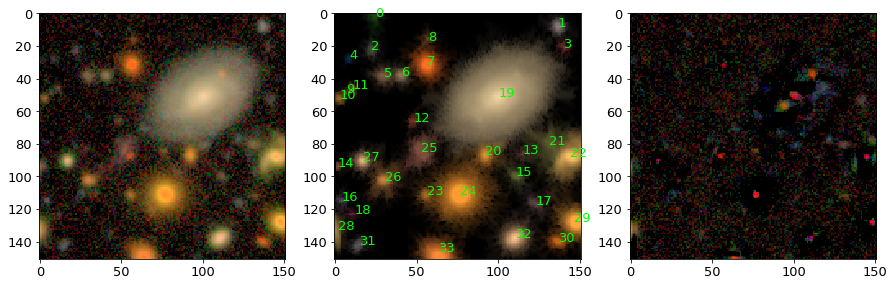

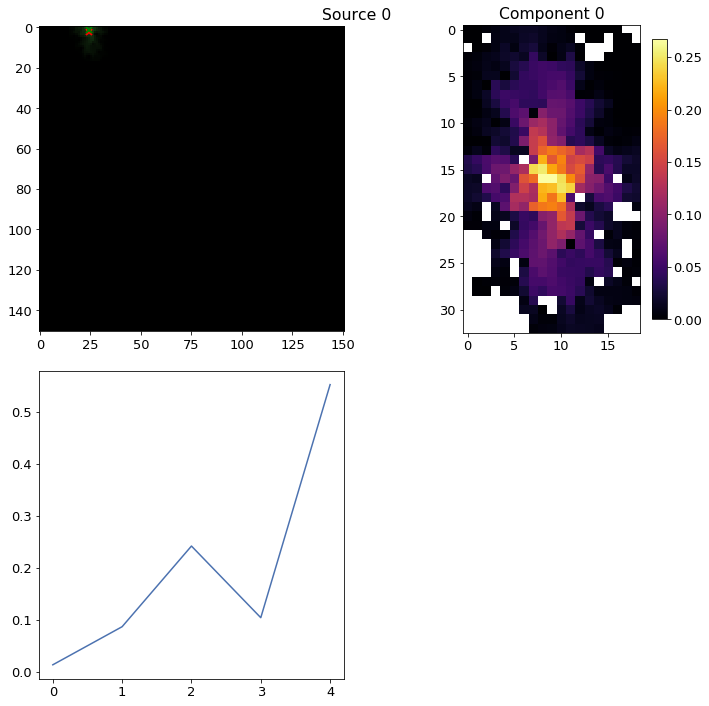

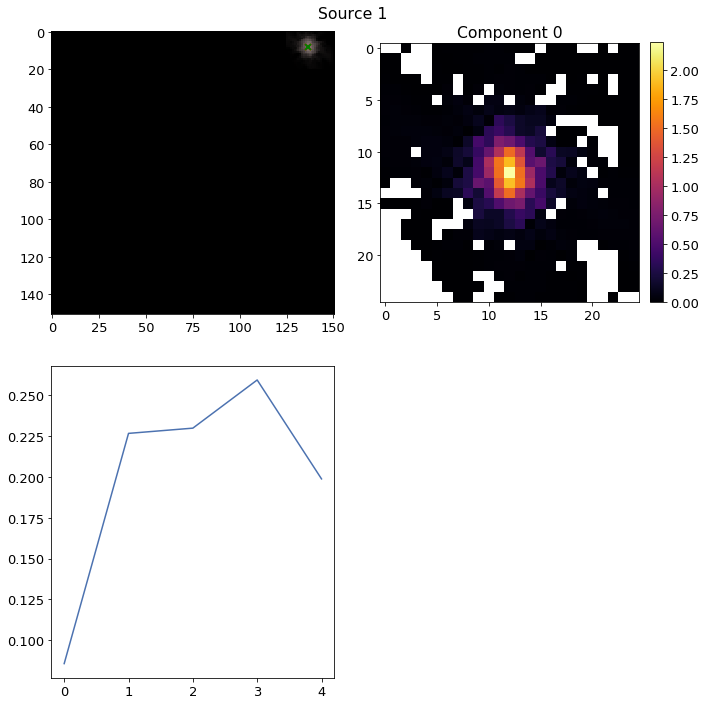

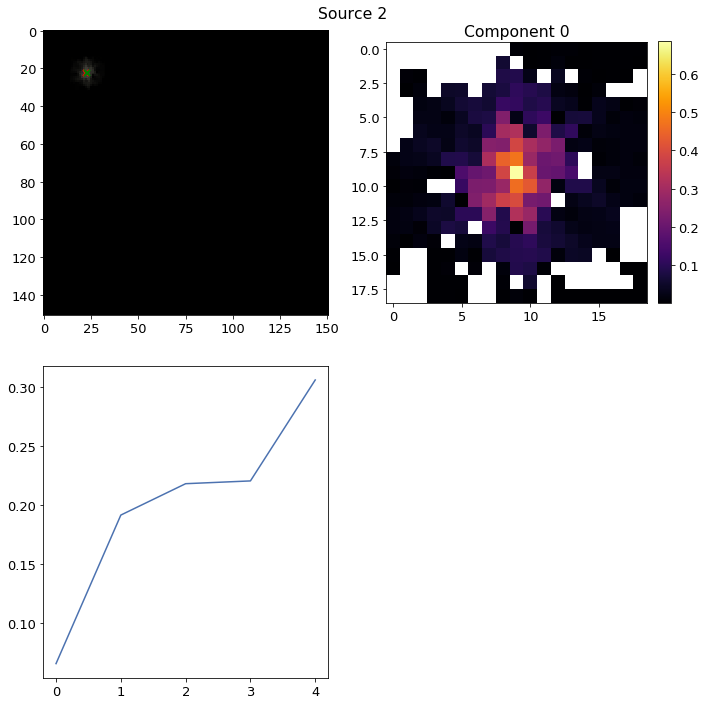

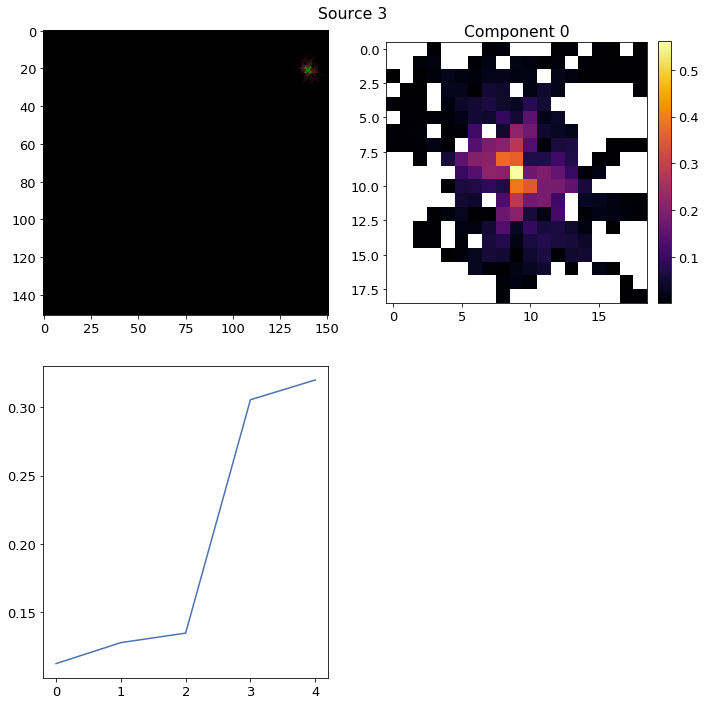

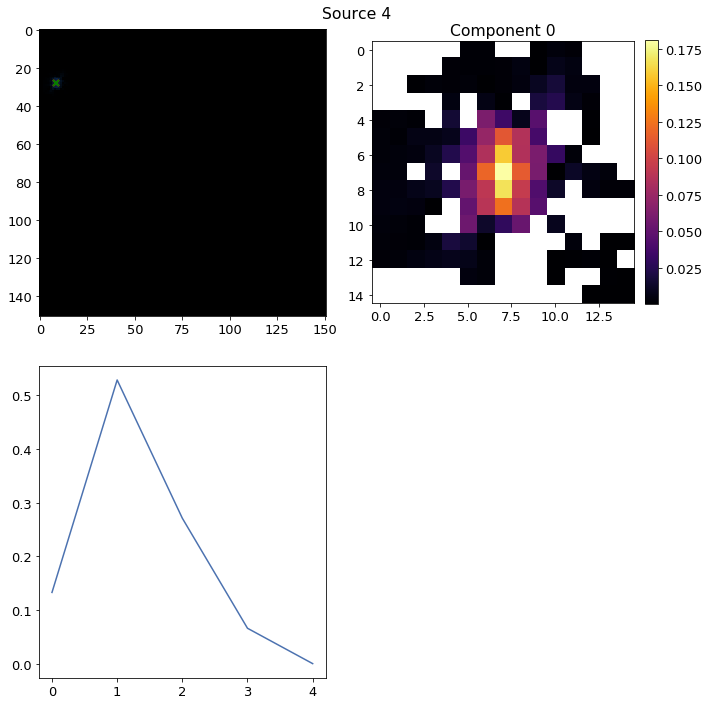

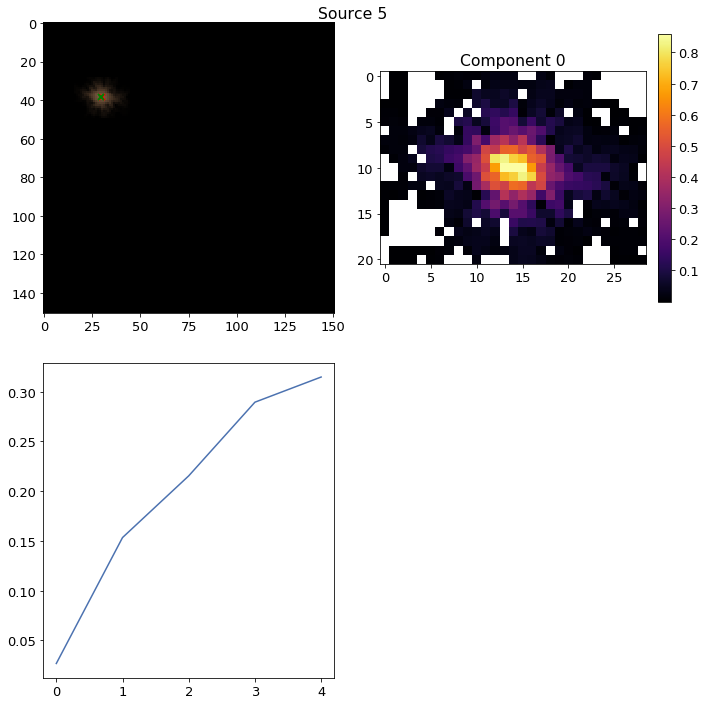

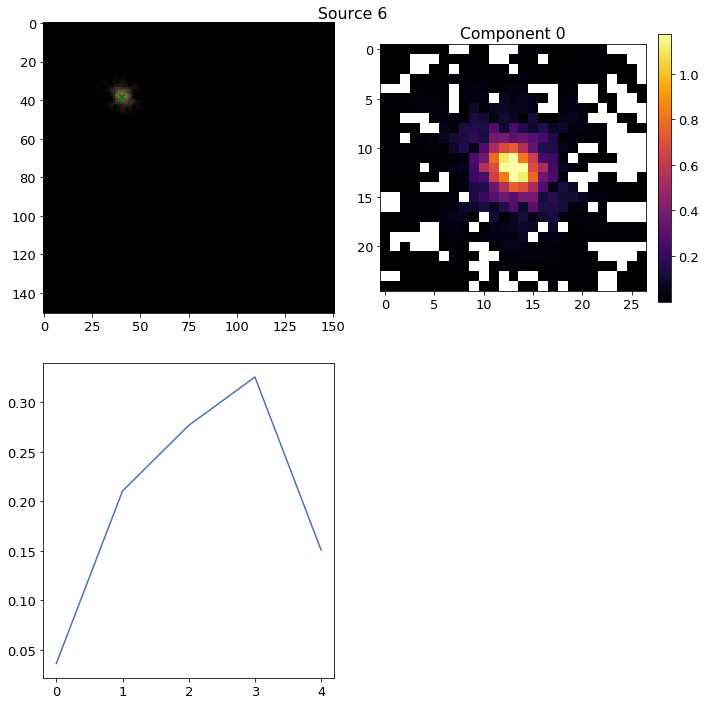

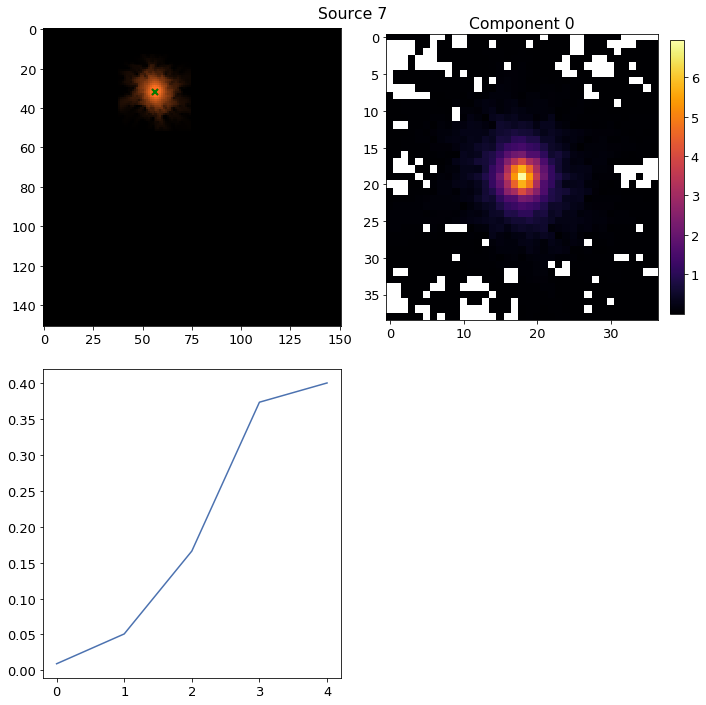

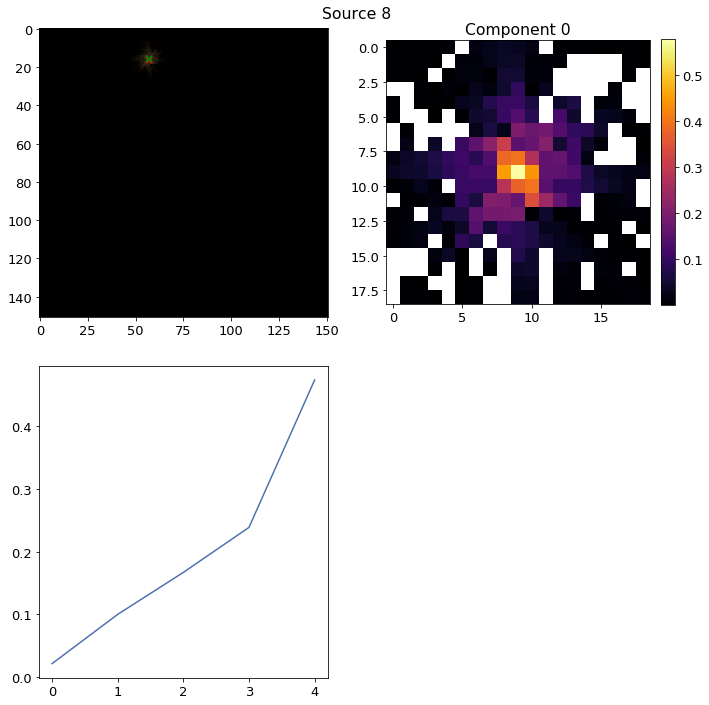

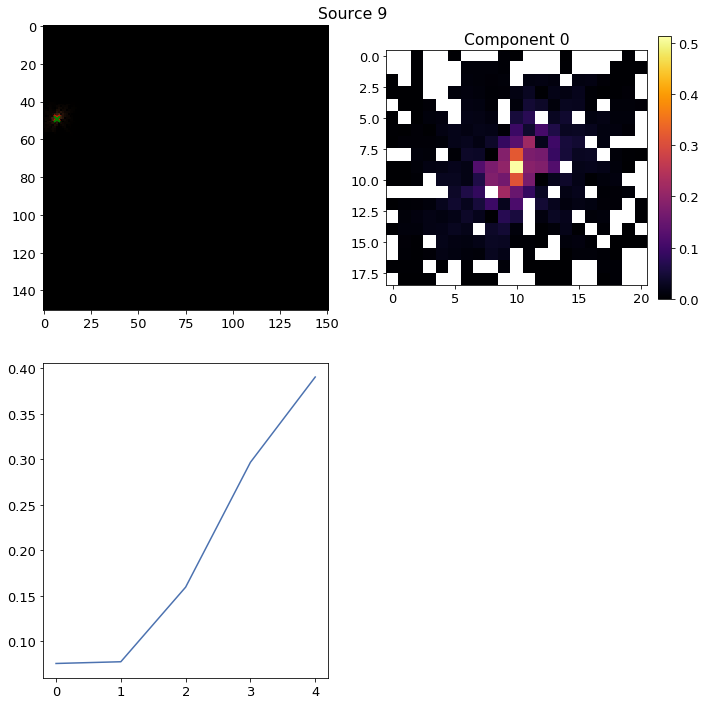

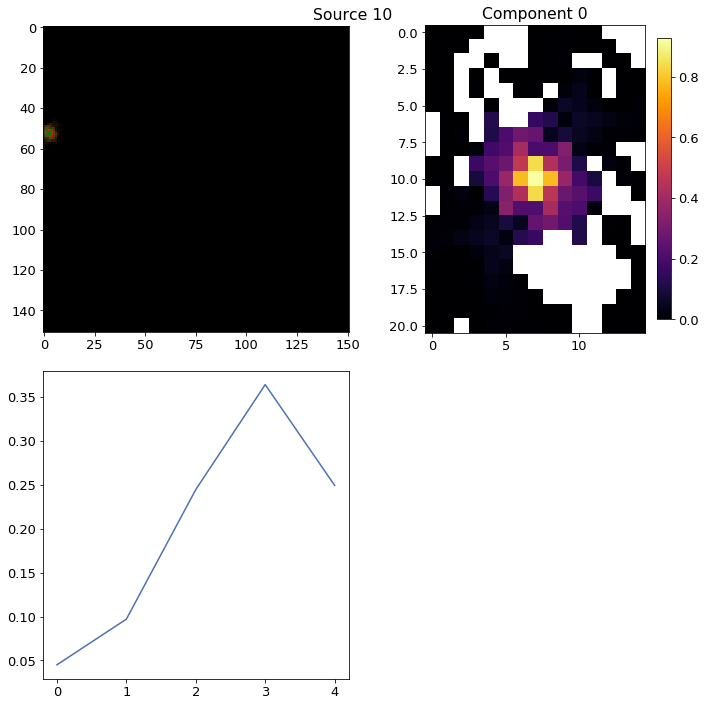

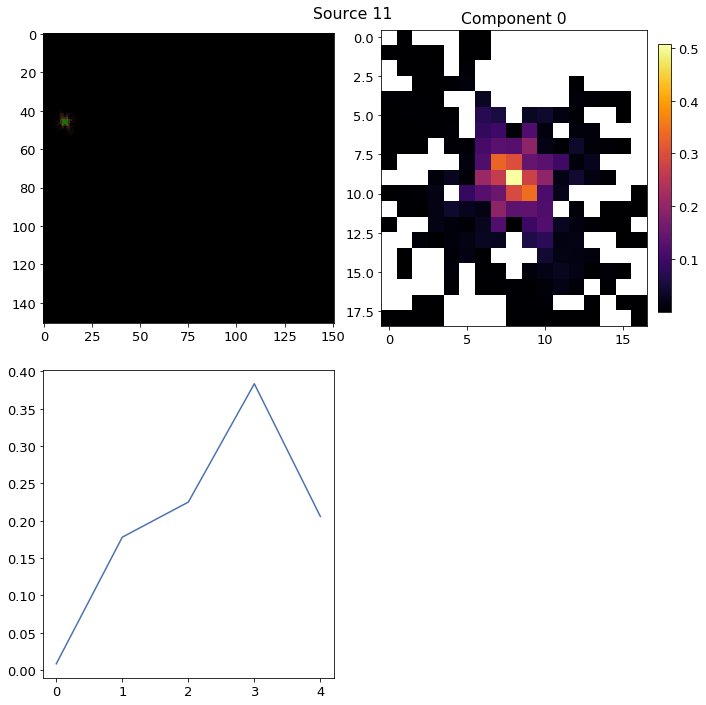

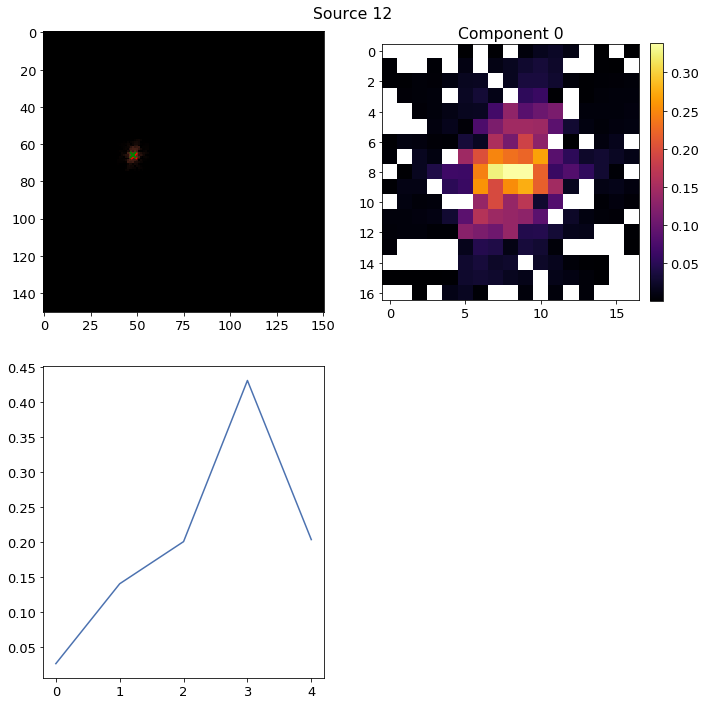

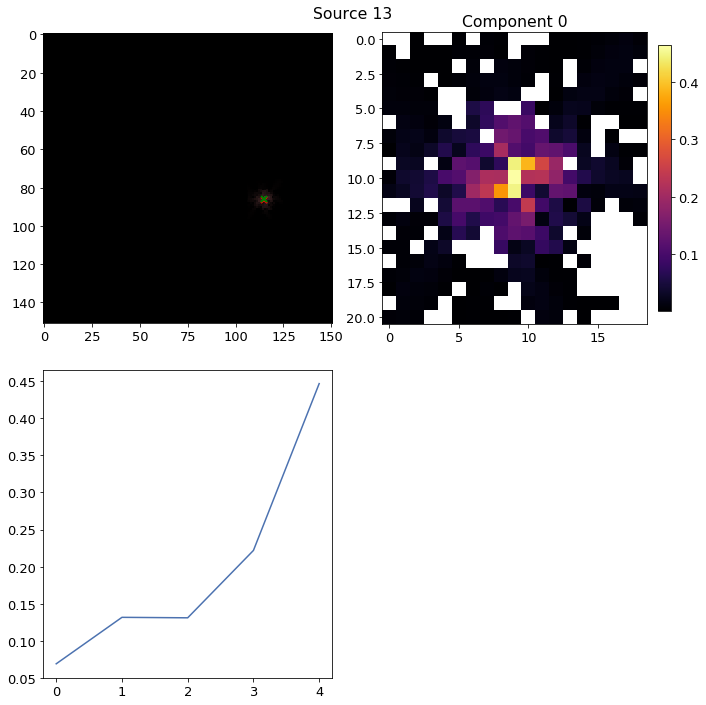

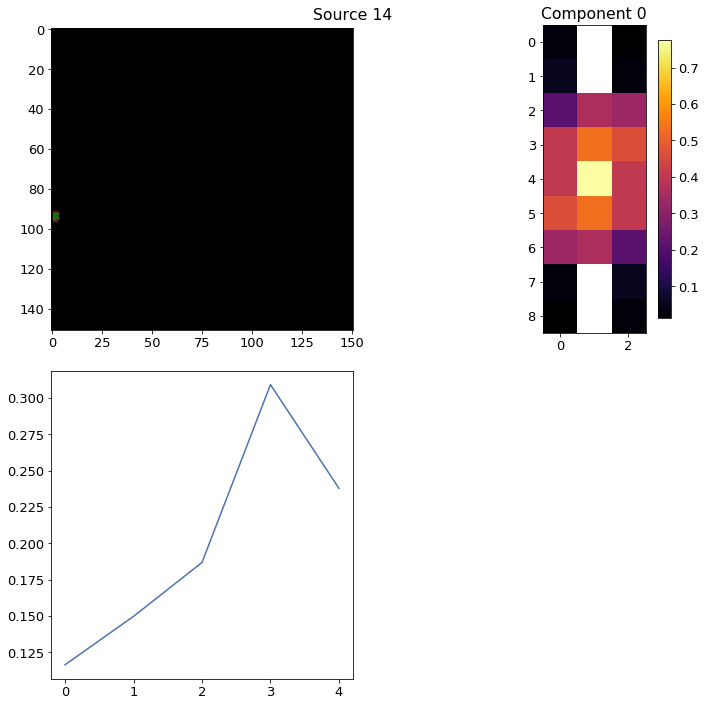

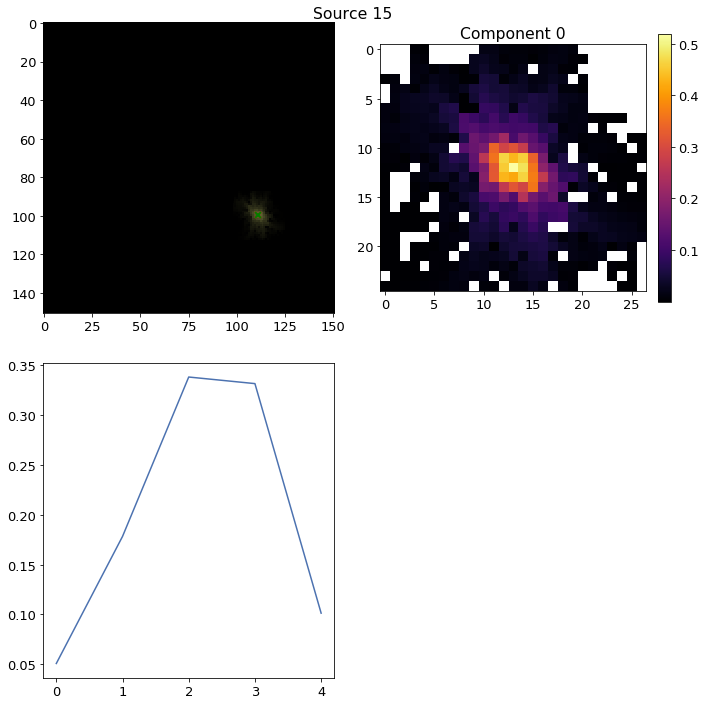

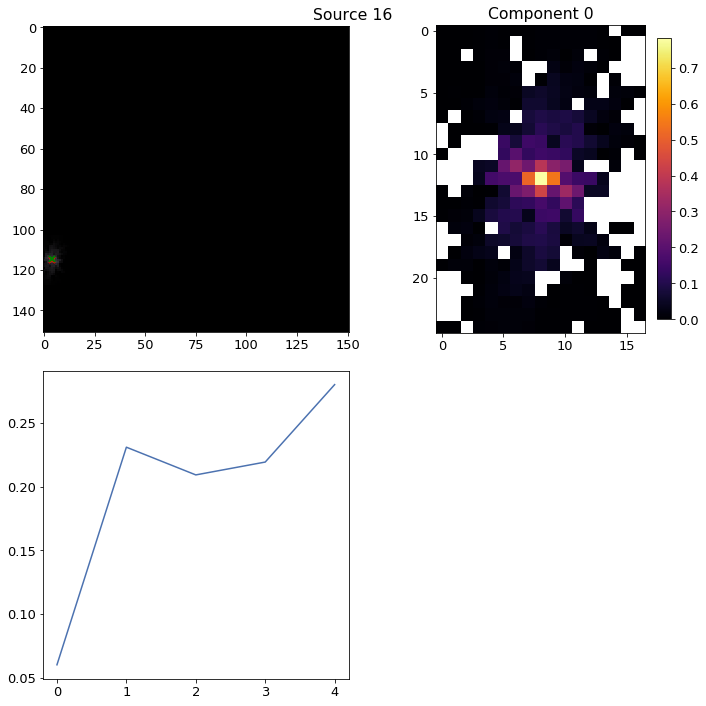

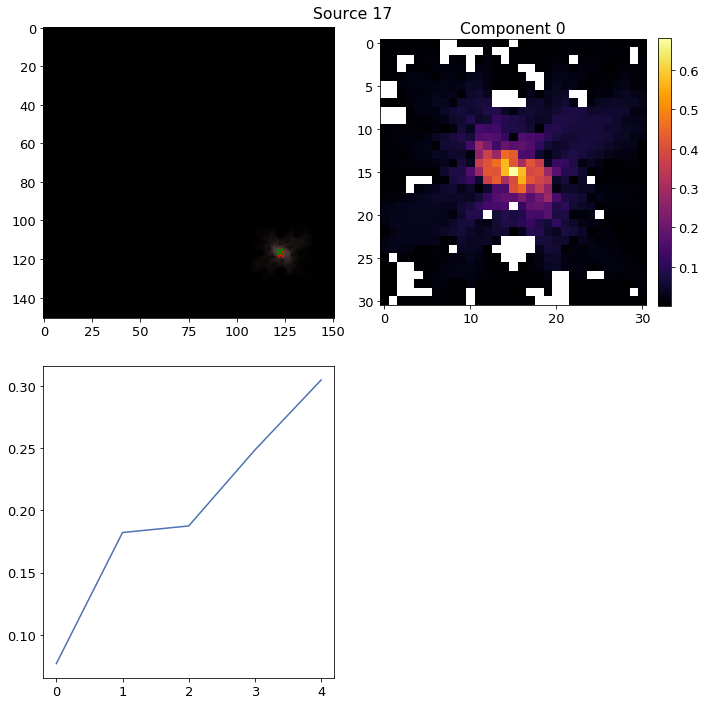

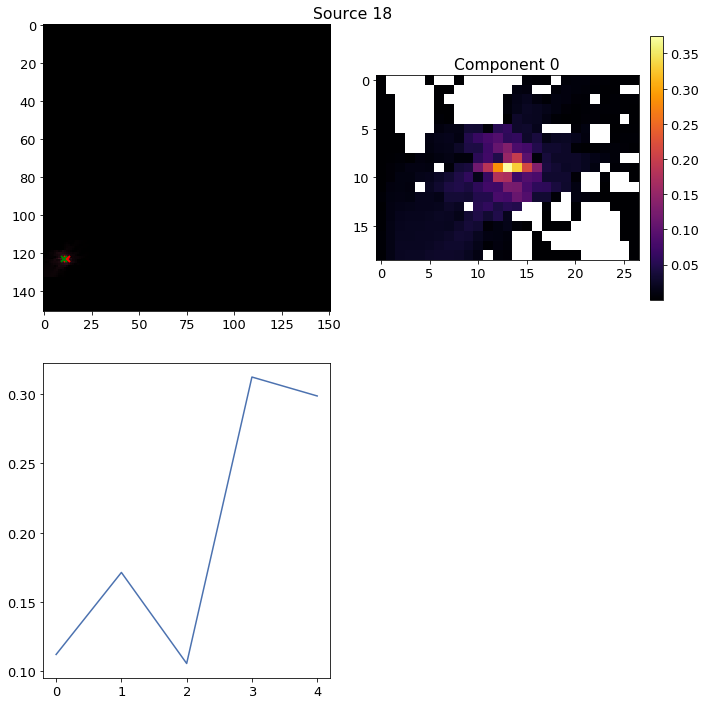

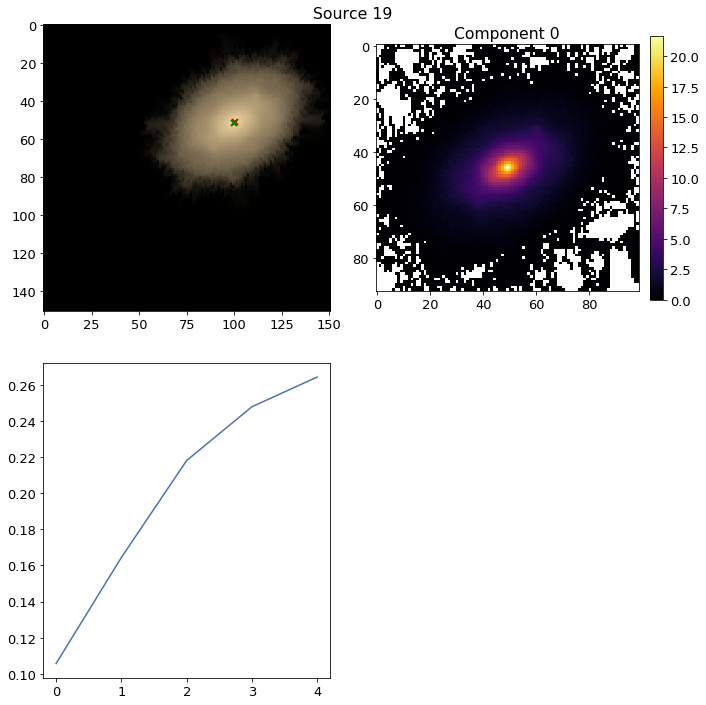

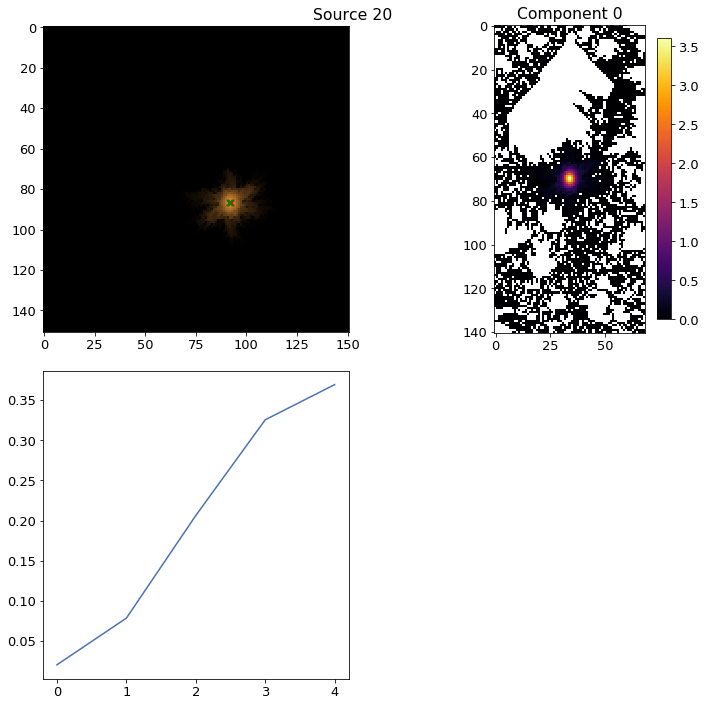

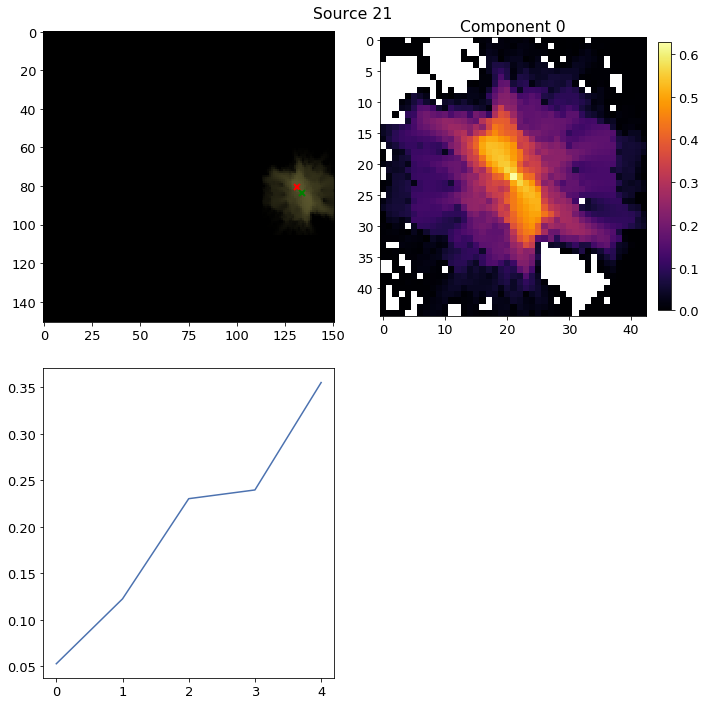

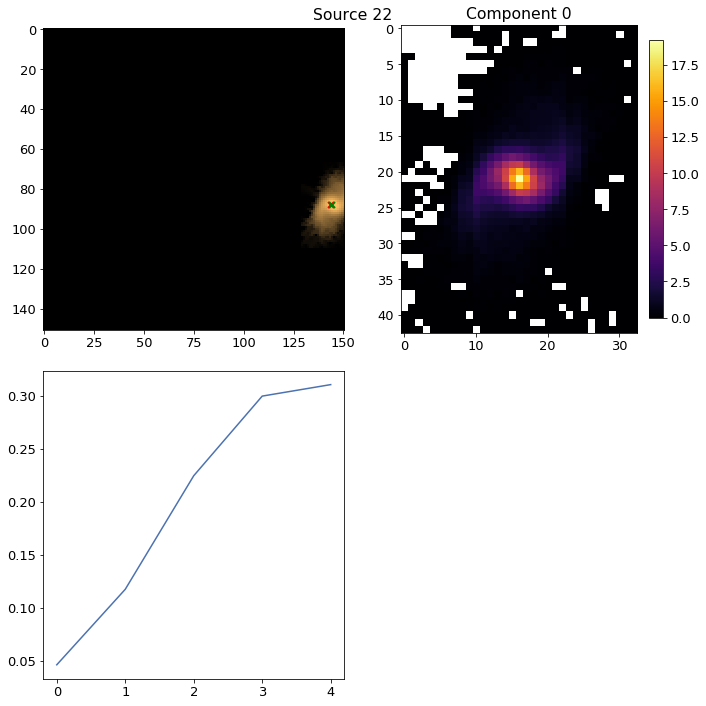

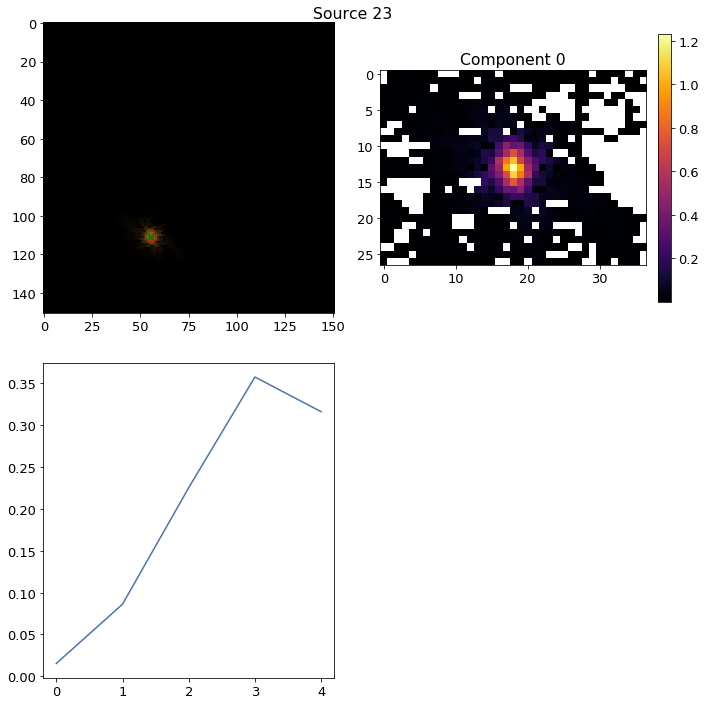

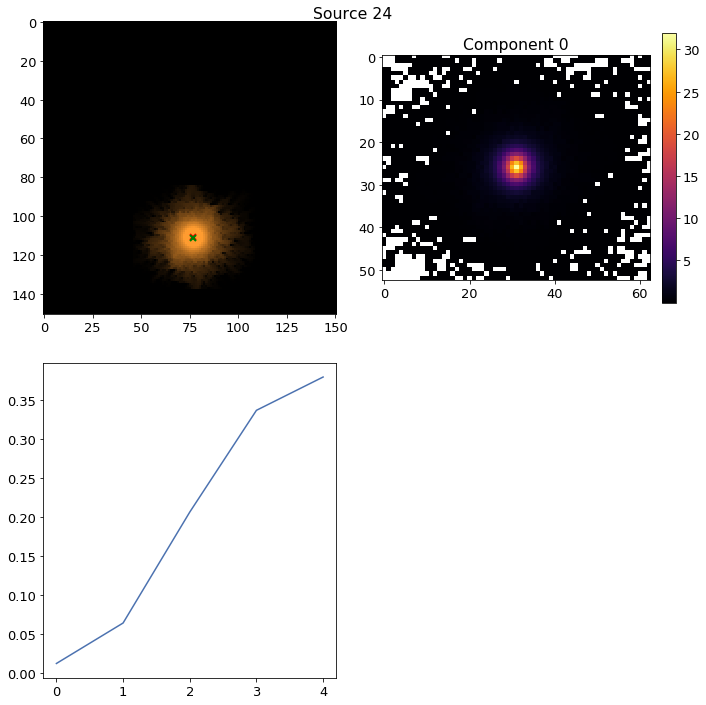

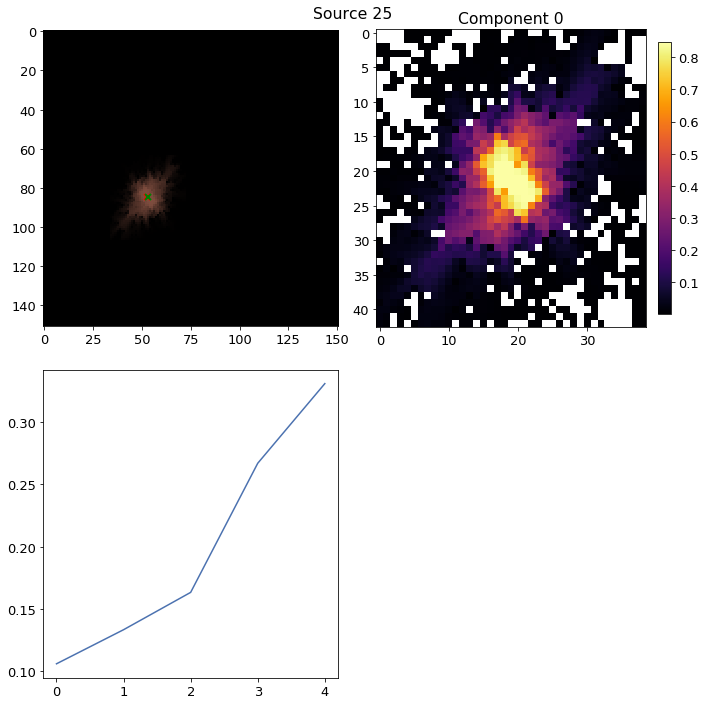

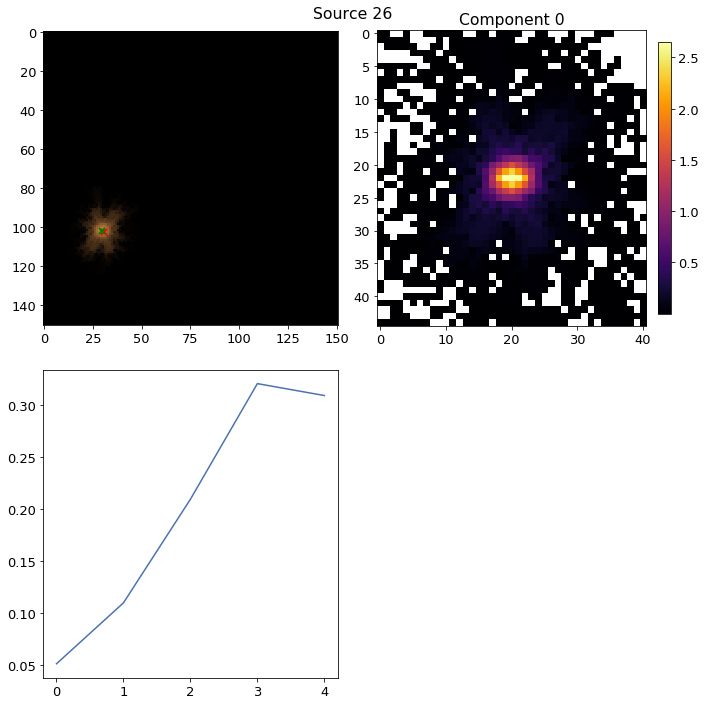

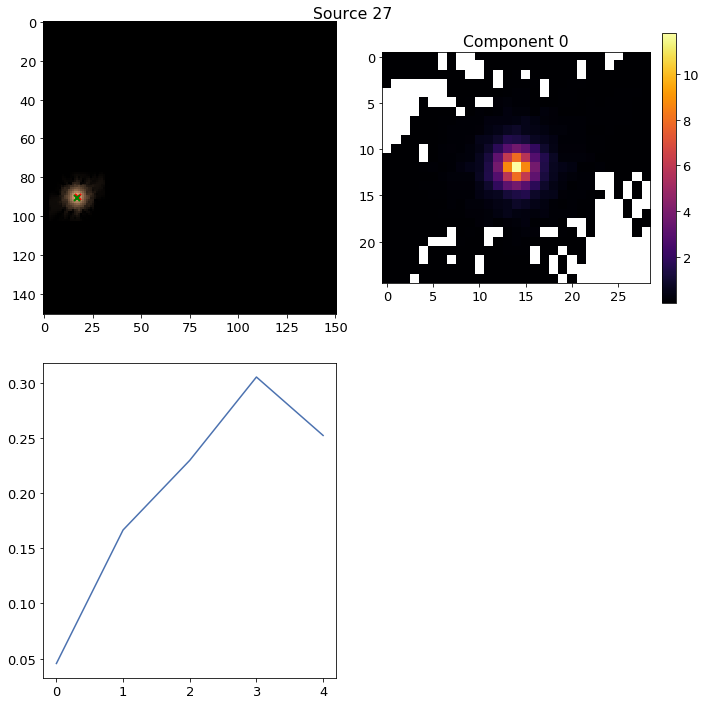

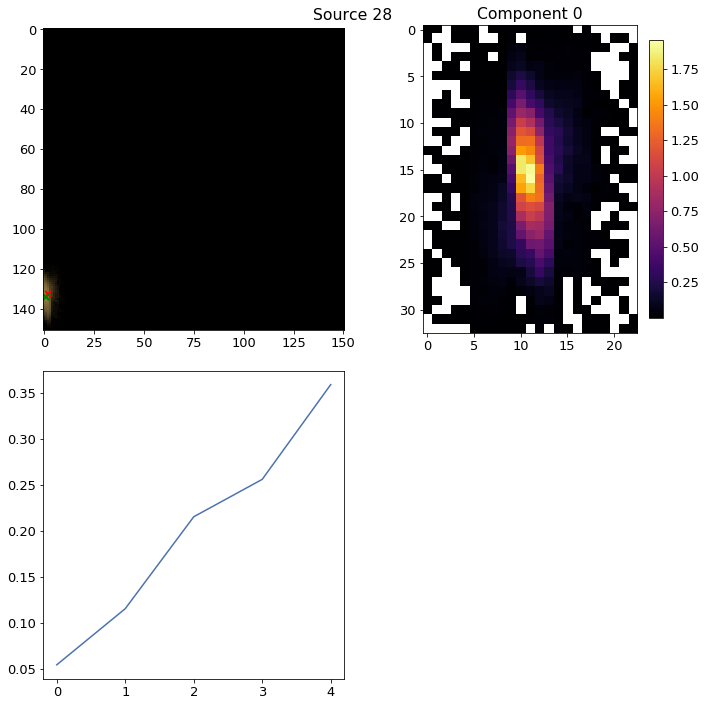

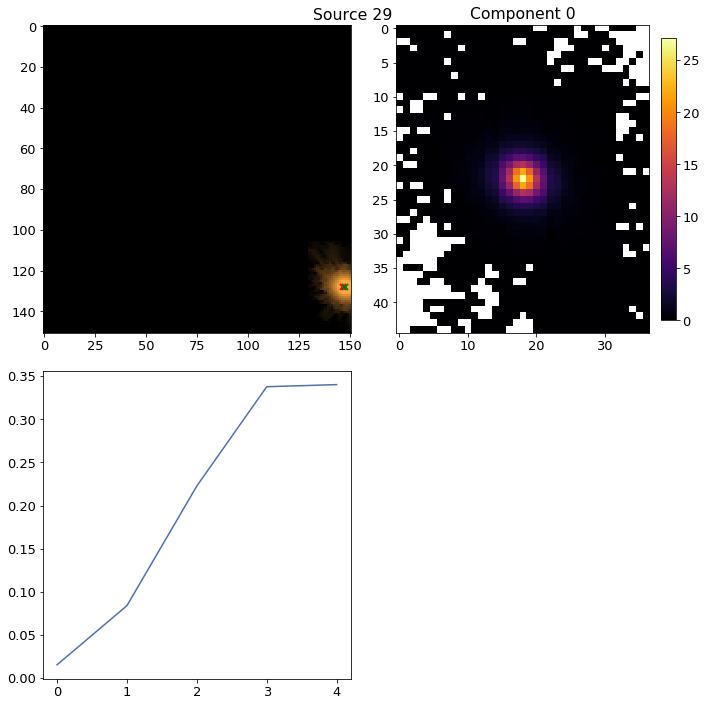

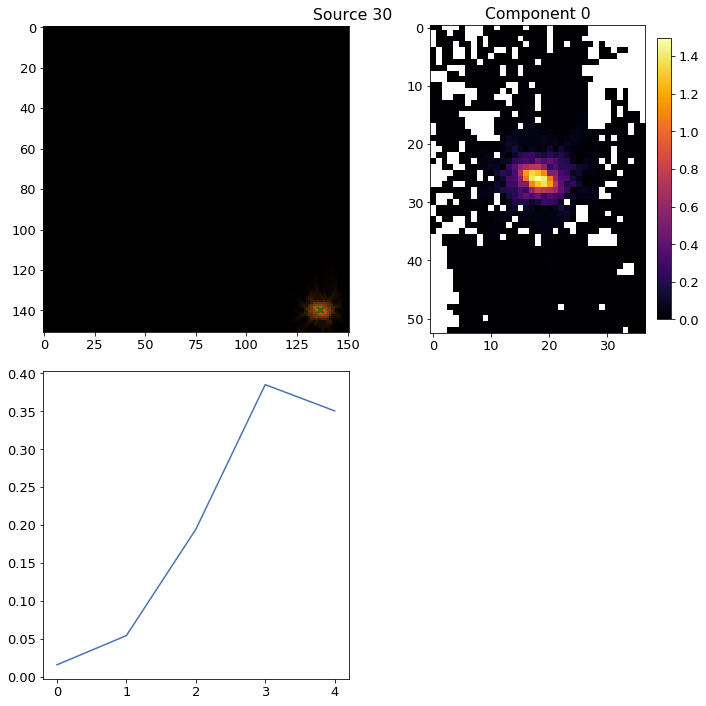

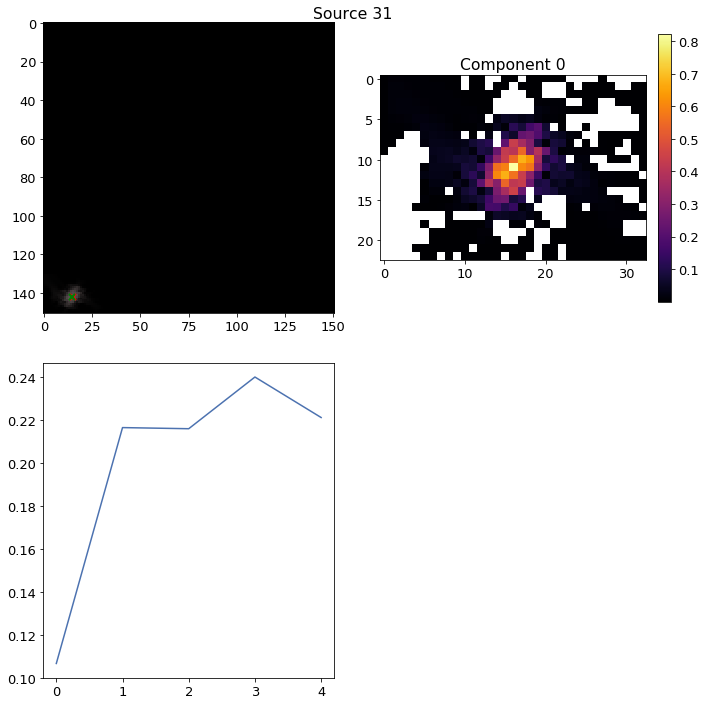

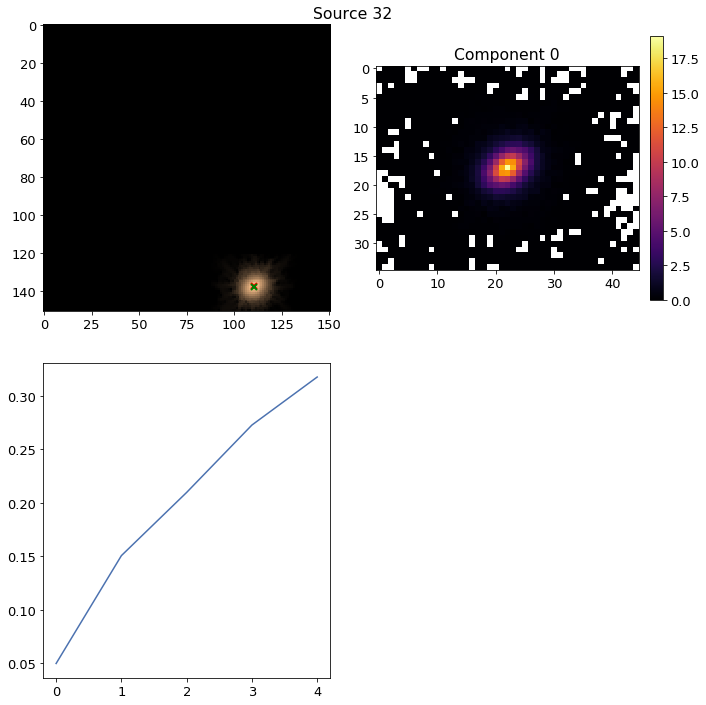

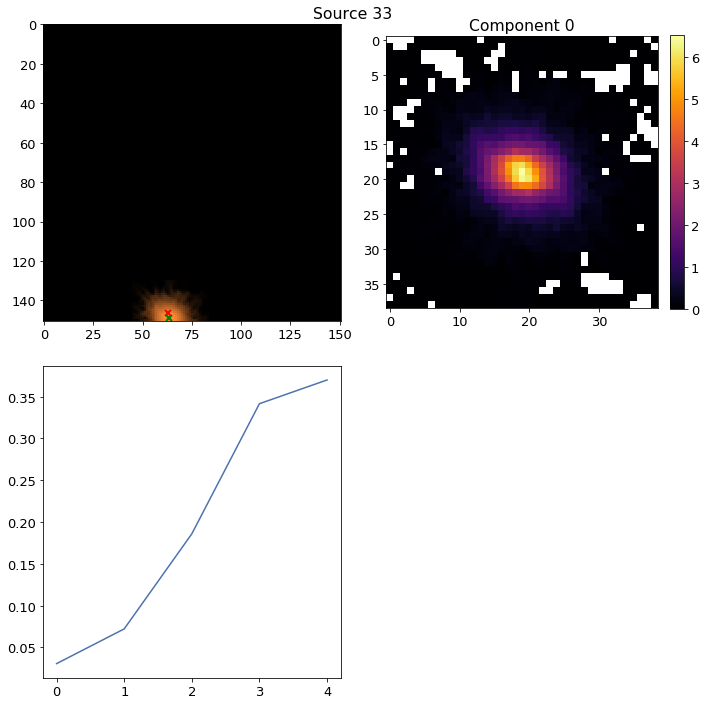

In [14]:
vmin = 0
vmax = .2

model = blend.get_model()
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
display.plotColorImage(images=img, filterIndices=[3,2,1], Q=8, vmin=vmin, vmax=vmax, ax=ax1, show=False)
display.plotColorImage(images=model, filterIndices=[3,2,1], Q=8, vmin=vmin, vmax=vmax, show=False, ax=ax2)
display.plotColorImage(images=img-model, filterIndices=[3,2,1], Q=8, vmin=vmin, vmax=vmax, show=False, ax=ax3)
#display.plotColorImage(images=img-model, filterIndices=[3,2,1], Q=8, show=False, ax=ax3)
for m,coord in enumerate(catalog):
    ax2.text(coord["x"], coord["y"], str(m), color="lime")
plt.show()

full_model = np.zeros_like(model)
for m in range(len(catalog)):
    model = blend.get_model(m=m)
    full_model += model
    sources = blend.sources[m].K
    rows = np.ceil((sources+2)/2)
    fig = plt.figure(figsize=(10,5*rows))
    ax = [fig.add_subplot(rows,2, n+1) for n in range(sources+2)]
    display.plotColorImage(images=model, filterIndices=[3,2,1], Q=8, show=False, vmin=vmin, vmax=vmax, ax=ax[0])
    #display.plotColorImage(images=model, filterIndices=[3,2,1], Q=8, show=False, vmin=vmin*0, vmax=vmax/20)
    ax[0].plot(catalog["x"][m], catalog["y"][m], 'rx', mew=2)
    y,x = blend.sources[m].center
    #ax1.scatter(x,y,s=80,facecolor='none',edgecolor='r')
    ax[0].plot(x, y, 'gx', mew=2)
    src = blend.sources[m]
    for k in range(src.K):
        morph = src.morph[k].reshape(src.Ny,src.Nx)
        im = ax[k+1].imshow(np.ma.array(morph, mask=morph==0))
        ax[k+1].set_title("Component {0}".format(k))
        fig.colorbar(im, ax=ax[k+1],fraction=0.046, pad=0.04)
    for n,sed in enumerate(src.sed):
        ax[-1].plot(sed, label="Component {0}".format(n))
    plt.suptitle("Source {0}".format(m))
    plt.tight_layout()
    plt.show()